In [35]:
import robin_stocks.robinhood as rh
from dotenv import dotenv_values
import logging
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
from functools import lru_cache

logging.basicConfig(level=logging.INFO)
cfg = dotenv_values(".env")

In [36]:
def login_robinhood():
    username = cfg["ROBINHOOD_USERNAME"]
    password = cfg["ROBINHOOD_PASSWORD"]
    rh.login(username, password)

In [37]:
def generate_integer_weights(n, total=100):
    weights = np.random.rand(n)
    weights = (weights / weights.sum()) * total
    rounded_weights = np.round(weights).astype(int)

    # Adjust the rounded weights to ensure they sum to the total
    difference = total - rounded_weights.sum()
    for i in range(abs(difference)):
        index = np.random.randint(0, n)
        if difference > 0:
            rounded_weights[index] += 1
        elif difference < 0:
            if rounded_weights[index] > 0:
                rounded_weights[index] -= 1
    return rounded_weights


def calculate_fitness(weights, etf_config, historical_prices_map):
    total_investment = 1000  # Total amount to invest
    etf_prices = None
    investment_values = np.zeros(
        len(list(historical_prices_map.values())[0])
    )  # Initialize array to track investment values over time

    for i, (symbol, percentage) in enumerate(etf_config.items()):
        prices_np_array = historical_prices_map[symbol]

        if etf_prices is None:
            etf_prices = prices_np_array
        else:
            etf_prices += prices_np_array

        # Calculate the amount invested in each stock
        amount_invested = total_investment * (weights[i] / 100)
        # Calculate the number of shares bought at the starting price
        num_shares = amount_invested / prices_np_array[0]
        # Calculate the value of the investment over time
        investment_values += num_shares * prices_np_array

    profit = investment_values[-1] - total_investment

    return profit


def mutate_weights_and_maintain_sum_constraint(weights, total=100):
    n = len(weights)
    # Choose a random index to mutate
    index = np.random.randint(0, n)
    # Choose a random value to add or subtract
    value = np.random.choice([-1, 1])
    # Mutate the weight at the chosen index
    new_weights = weights.copy()
    new_weights[index] += value
    # Adjust the new weights to maintain the sum constraint
    difference = total - new_weights.sum()
    if difference != 0:
        new_weights[index] += difference
    return new_weights


def maximize_etf_function(etf_config: dict, historical_prices_map: dict):
    n_iters = 500
    generations = 500
    fitness_values = []
    n = len(list(etf_config.values()))
    weights = generate_integer_weights(n)
    print(weights)
    print("Sum of weights:", weights.sum())
    best_weights = weights.copy()
    for i in range(n_iters):
        # print(f"Iteration {i + 1}")

        if calculate_fitness(weights, etf_config, historical_prices_map) > calculate_fitness(
            best_weights, etf_config, historical_prices_map
        ):
            best_weights = weights.copy()

        if i % 20 == 0:
            # mutate weights and maintain sum constraint
            weights = mutate_weights_and_maintain_sum_constraint(weights)

        for j in range(generations):
            # print(f"Generation {j + 1}")
            # Calculate the fitness of the current solution
            fitness = calculate_fitness(weights, etf_config, historical_prices_map)
            fitness_values.append(fitness)
            # print("Fitness:", fitness)

            # Generate a new solution
            new_weights = generate_integer_weights(n)
            new_fitness = calculate_fitness(new_weights, etf_config, historical_prices_map)

            # Compare the fitness of the new solution with the current solution
            if new_fitness > fitness:
                weights = new_weights
                # print("New weights accepted")
            else:
                pass
                # print("New weights rejected")

        # print("Final weights:", weights)

    # print optimized etf config
    optimized_etf_config = {symbol: weight for symbol, weight in zip(etf_config.keys(), best_weights)}
    print("Optimized ETF Config:", optimized_etf_config)

    # Optimized Profit
    optimized_profit = calculate_fitness(best_weights, etf_config, historical_prices_map)
    print("Optimized Profit:", optimized_profit)

    # plot the fitness values across iterations
    # x axis is iteration number
    # y axis is fitness value
    plt.figure(figsize=(14, 7))
    plt.plot(fitness_values)
    plt.title("Fitness Values Across Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.show()


@lru_cache(maxsize=128)
def get_stock_price(symbol):
    print(f"Fetching historical prices for {symbol}")
    historical_prices = rh.stocks.get_stock_historicals(
        symbol, span="3month", bounds="regular"
    )
    return historical_prices


def extract_close_prices(historical_prices):
    return [float(price["close_price"]) for price in historical_prices]

In [38]:
def plot_etf_prices(etf_prices, investment_values):
    # Plot the ETF prices array
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    plt.title("Custom ETF Chart (last 3 months closing price)")
    (line1,) = plt.plot(etf_prices, label="Average ETF Prices")
    plt.legend()

    # Plot the investment value over time
    plt.subplot(2, 1, 2)
    plt.title("Investment Value Over Time")
    (line2,) = plt.plot(investment_values, label="Investment Value")
    plt.legend()

    # Add mplcursors for interactive tooltips
    cursor1 = mplcursors.cursor(line1, hover=True)
    cursor1.connect(
        "add",
        lambda sel: sel.annotation.set_text(f"Price: {etf_prices[int(sel.index)]:.2f}"),
    )

    cursor2 = mplcursors.cursor(line2, hover=True)
    cursor2.connect(
        "add",
        lambda sel: sel.annotation.set_text(
            f"Value: ${investment_values[int(sel.index)]:.2f}"
        ),
    )

    plt.tight_layout()
    plt.show()


def main():
    login_robinhood()
    etf_config = {
        "NVDA": 40,
        "NVDL": 30,
        "NVDX": 10,
        "NVDU": 10,
        "NVD": 10,
    }

    total_investment = 200  # Total amount to invest
    etf_prices = None
    investment_values = np.zeros(
        len(get_stock_price("NVDA"))
    )  # Initialize array to track investment values over time

    historical_prices_map = {}

    investment_values_array = []

    for symbol, percentage in etf_config.items():
        symbol_historical_price = get_stock_price(symbol)
        prices_np_array = np.array(extract_close_prices(symbol_historical_price))

        historical_prices_map[symbol] = prices_np_array

        if etf_prices is None:
            etf_prices = prices_np_array
        else:
            etf_prices += prices_np_array

        # Calculate the amount invested in each stock
        amount_invested = total_investment * (percentage / 100)
        # Calculate the number of shares bought at the starting price
        num_shares = amount_invested / prices_np_array[0]
        # Calculate the value of the investment over time
        investment_values += num_shares * prices_np_array

        investment_values_array.append(investment_values)

    etf_prices = etf_prices / len(etf_config)

    profit = investment_values[-1] - total_investment

    print(f"Total investment: ${total_investment}")

    print(f"Total profit: ${profit:.2f}")

    # plot_etf_prices(etf_prices, investment_values)

    # logging.info(f"Total invested: ${total_investment}")

    maximize_etf_function(etf_config, historical_prices_map)

Fetching historical prices for NVDA
Fetching historical prices for NVDL
Fetching historical prices for NVDX
Fetching historical prices for NVDU
Fetching historical prices for NVD
Total investment: $200
Total profit: $154.41
[30 15 24 19 12]
Sum of weights: 100
Optimized ETF Config: {'NVDA': 5, 'NVDL': 41, 'NVDX': 49, 'NVDU': 6, 'NVD': 0}
Optimized Profit: 1245.9381925051357


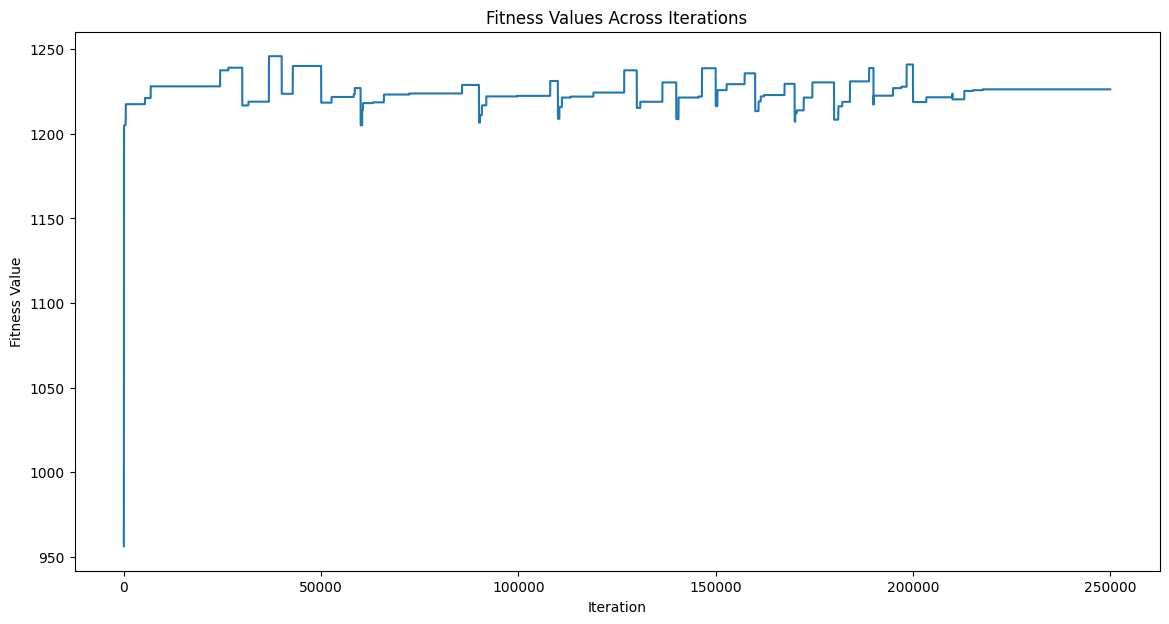

In [39]:
main()